In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib as mpl

plt.rcParams.update({
    'font.family': 'Arial',  # 设置全局字体
    'axes.unicode_minus': False  # 解决负号显示问题
})
mpl.rcParams.update({
    'font.size': 18,         # 全局文本字体大小
    'axes.titlesize': 16,      # 坐标轴标题字体大小
    'axes.labelsize': 20,      # 坐标轴标签字体大小
    'xtick.labelsize': 16,     # x轴刻度标签字体大小
    'ytick.labelsize': 18,     # y轴刻度标签字体大小
    'legend.fontsize': 18,     # 图例字体大小
    'figure.titlesize': 24,    # 整体图标题大小
})

colors = ["#74AED4", "#F7C97E", "#ECA8A9", "#C6CF9D"]


d = "../../../学术/项目/Chimera/Experiment/Classify/benchmark_results_maxhashs"
# 假设在每个文件夹里找 *abundance.csv
csv_pattern = os.path.join(d, "*classification.csv")
csv_files = glob.glob(csv_pattern)
all_csv_files = []
all_csv_files.extend(csv_files)
sns.set_palette("deep") 


In [3]:
df_list = []
for f in csv_files:
    df_tmp = pd.read_csv(f)
    
    basename = os.path.basename(f)
    db_name = "unknownDB"
    parts = basename.split("_")
    for p in parts:
        if p.startswith("complete"):
            db_name = p
            break
    
    df_tmp["Database"] = db_name
    df_list.append(df_tmp)

df_all = pd.concat(df_list, ignore_index=True)
print("合并后的 DataFrame 大小：", df_all.shape)

合并后的 DataFrame 大小： (700, 11)


In [4]:
df_grouped = df_all.groupby(["Database","Taxonomic Rank"], as_index=False).agg({
    "Accuracy":  "mean",
    "Precision": "mean",
    "Recall":    "mean",
    "F1 Score":  "mean"
})

########################################
# 2) 只保留 Species Rank
########################################
df_species = df_grouped[df_grouped["Taxonomic Rank"]=="Species"].copy()

########################################
# 3) 数据库顺序 & 大小映射(GB)
########################################
db_order = [
    "complete100w", "complete200w", "complete300w", "complete400w", "complete500w",
    "complete1000w","complete2000w","complete5000w","complete1e",   "completeUnlimit"
]

db_rename_map = {
    "complete100w":     "1",
    "complete200w":     "2",
    "complete300w":     "3",
    "complete400w":     "4",
    "complete500w":     "5",
    "complete1000w":    "10",
    "complete2000w":    "20",
    "complete5000w":    "50",
    "complete1e":       "100",
    "completeUnlimit":  "No Limit"
}


db_size_map = {
    "complete100w":     41.1,
    "complete200w":     49.1,
    "complete300w":     53.6,
    "complete400w":     57.1,
    "complete500w":     60.0,
    "complete1000w":    79.4,
    "complete2000w":    178.6,
    "complete5000w":    208.0,
    "complete1e":       227.1,
    "completeUnlimit":  320.0
}

truncated_taxa_map = {
    "complete100w":     2786,
    "complete200w":     1013,
    "complete300w":     693,
    "complete400w":     543,
    "complete500w":     447,
    "complete1000w":    229,
    "complete2000w":    122,
    "complete5000w":    49,
    "complete1e":       23,
    "completeUnlimit":  0
}

########################################
# 4) 只保留在 db_order 里的数据库，并按顺序排好
########################################
df_species = df_species[df_species["Database"].isin(db_order)].copy()
df_species.set_index("Database", inplace=True)

for db in db_order:
    if db not in df_species.index:
        df_species.loc[db] = [np.nan, np.nan, np.nan, np.nan, "Species"]

df_species = df_species.loc[db_order]  # 按固定顺序

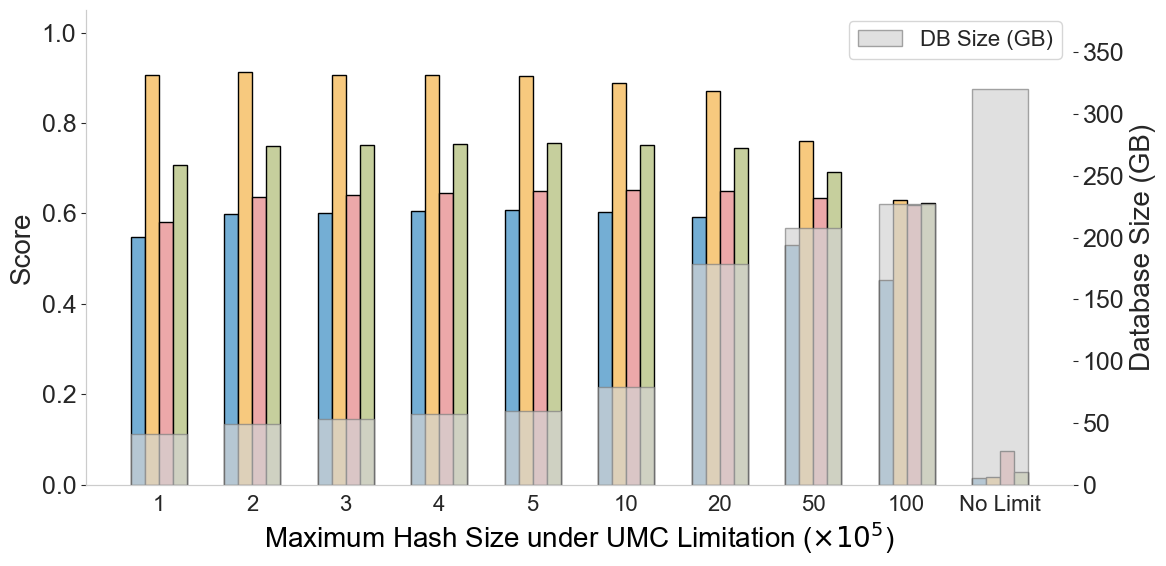

In [7]:
########################################
# 5) 作图：双 y 轴 (左：4个指标，右：数据库大小)
########################################
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()  # 右 y 轴

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
n_metrics = len(metrics)

# x 轴位置
indices = np.arange(len(db_order))

# 给一组中(4个指标)留多大宽度
group_width = 0.6
bar_width   = group_width / n_metrics

# ---------- (A) 画 4 个性能指标的小柱 (在左 y 轴) ----------
for i, metric in enumerate(metrics):
    # 每个 metric 的数值
    metric_vals = df_species[metric].values.astype(float)  # 如果有NaN，需要处理
    # 让这4个小柱在 x=indices 的周围均分
    # x_center = indices；为了错开，就要加 offset
    x_offset = (i + 0.5)*bar_width - group_width/2.0
    x_positions = indices + x_offset
    
    ax1.bar(
        x=x_positions,
        height=metric_vals,
        width=bar_width,
        edgecolor="black",
        label=metric,      # 给每个指标都加label
        color=colors[i],  # 指定颜色
        zorder=3           # 画在灰色柱(数据库大小)上方
    )

ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Score")

# ---------- (B) 画数据库大小(GB) (在右 y 轴) ----------
db_sizes_gb = [db_size_map.get(db, 0) for db in db_order]

# 灰色大柱居中在 indices
ax2.bar(
    x=indices,
    height=db_sizes_gb,
    width=group_width,
    color="lightgray",
    edgecolor="gray",
    alpha=0.7,
    label="DB Size (GB)",
    zorder=1
)



ax2.set_ylim(0, max(db_sizes_gb) * 1.2)
ax2.set_ylabel("Database Size (GB)")


# ---------- (C) 设置 x 轴 ----------
# 刻度位置=indices；标签=重命名后的数据库名
ax1.set_xlabel(r"Maximum Hash Size under UMC Limitation ($\times 10^5$)", color='black')
ax1.set_xticks(indices)
ax1.set_xticklabels([db_rename_map.get(db, db) for db in db_order],
                    rotation=0,         # 不旋转
                    ha="center")        # 水平居中

# ---------- (D) 图例 ----------
# 把指标的图例放在左上，把数据库大小的图例放在右上
# ax1.legend(loc="upper left", fontsize=12, ncol=2)
ax2.legend(loc="upper right", fontsize=16)

# ---------- (E) 网格线 ----------
# 去掉 ax2 的网格线，以免和 ax1 的网格线叠加
ax2.grid(False)
# ax1 默认是 whitegrid 风格，可以只保留 y 轴网格
ax1.grid(False)
# ---------- (F) 标题 & 布局 ----------
# ax1.set_title("Impact of Different Maximum Hash Sizes on Classification Performance and Database Size", fontsize=16)
sns.despine(top=True)
plt.tight_layout()
plt.show()

In [8]:
# 保存图片为svg和pdf格式
fig.savefig("maxhashs.svg", format="svg", bbox_inches="tight")